In [ ]:
# Here we are forecasting for the next 226 days

In [ ]:
# importing the required libraries

In [47]:
import itertools

import numpy as np
from random import gauss, shuffle 

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse
from scipy.stats import shapiro, probplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import KMeans

import os


from  datetime import datetime, timedelta
import gc, copy

from gensim.models import Word2Vec
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from lightgbm import LGBMRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import STL

In [ ]:
# link to the dataset: 
#https://herts365-my.sharepoint.com/:x:/r/personal/sm22acy_herts_ac_uk/Documents/MSc_Project_21078559/food_validation.xlsx?d=w85ec0931a29248caa3c82f9453fc889e&csf=1&web=1&e=OSRomX

In [48]:
sales_data = pd.read_excel('food_validation.xlsx')

sales_data.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,FOODS_3_555_CA_1_validation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,23,16,14,10,...,10,32,26,13,21,15,14,14,23,24


In [ ]:
# the reduce_mem_usage function which iterates through each feature and 
# checks which features fall into which integer and floating data type bands.
# for example, if feature x requires just int 16 but it has been assigned int 32. 
# Then the function, converts the int 32 into int 16 thus saving memory and computational resources 

In [49]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if col_type =='category': 
            df[col] = df[col].astype('category').cat.as_ordered()
            #faced an error where you cannot calculate the max and min value that an category can take
        
        elif col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


sales_data = reduce_mem_usage(sales_data)

Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.00 MB
Decreased by 86.5%


In [ ]:
# data preprocessing

In [50]:
data = pd.melt(sales_data, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sales')

In [51]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,FOODS_3_555_CA_1_validation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,d_1,23
1,FOODS_3_555_CA_1_validation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,d_2,16
2,FOODS_3_555_CA_1_validation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,d_3,14
3,FOODS_3_555_CA_1_validation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,d_4,10
4,FOODS_3_555_CA_1_validation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,d_5,17


In [ ]:
# plotting the sales data

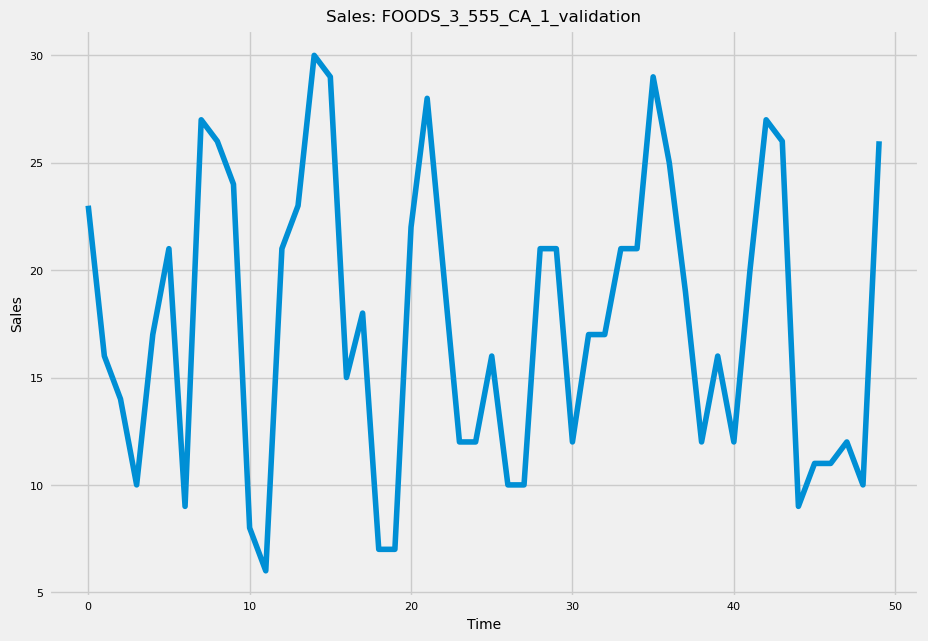

In [52]:
plt.plot(data['sales'].head(50))

plt.xlabel('Time', fontsize=10)
plt.ylabel('Sales', fontsize=10)
plt.title('Sales: FOODS_3_555_CA_1_validation', fontsize=12)

# Adjusting the size of x-ticks and y-ticks
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)

# Save the plot with adjusted fonts
plt.savefig('FOODS_3_555_CA_1_validation.png')

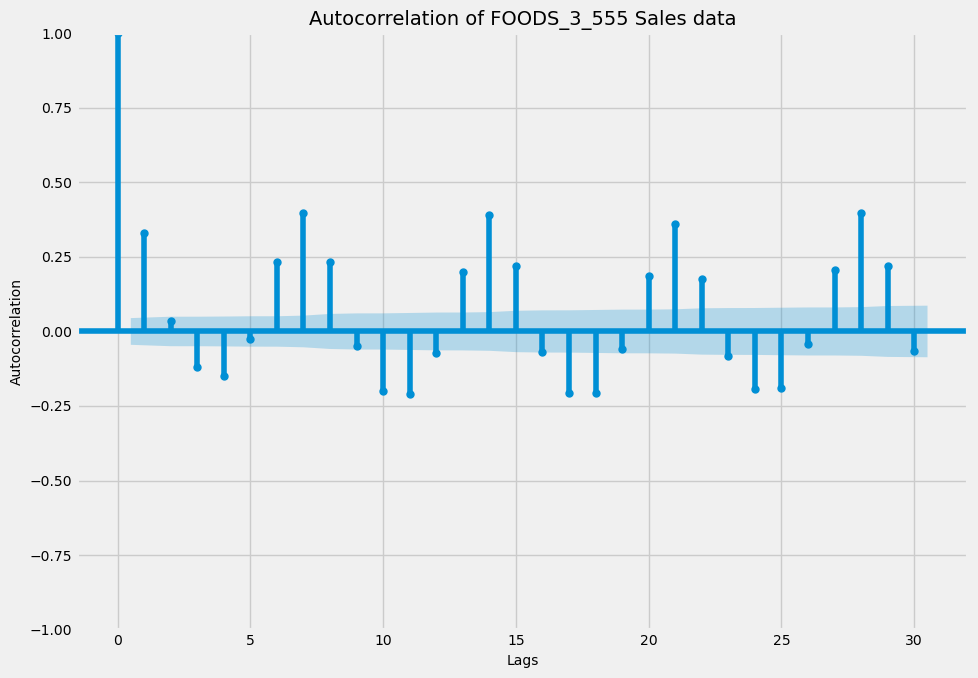

In [53]:
plot_acf(data['sales'], lags=30)
plt.title('Autocorrelation of FOODS_3_555 Sales data', fontsize= 14)
plt.xlabel('Lags', fontsize=10)
plt.ylabel('Autocorrelation', fontsize=10)
# Customize the x-ticks and y-ticks size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('acf.png')
plt.show()

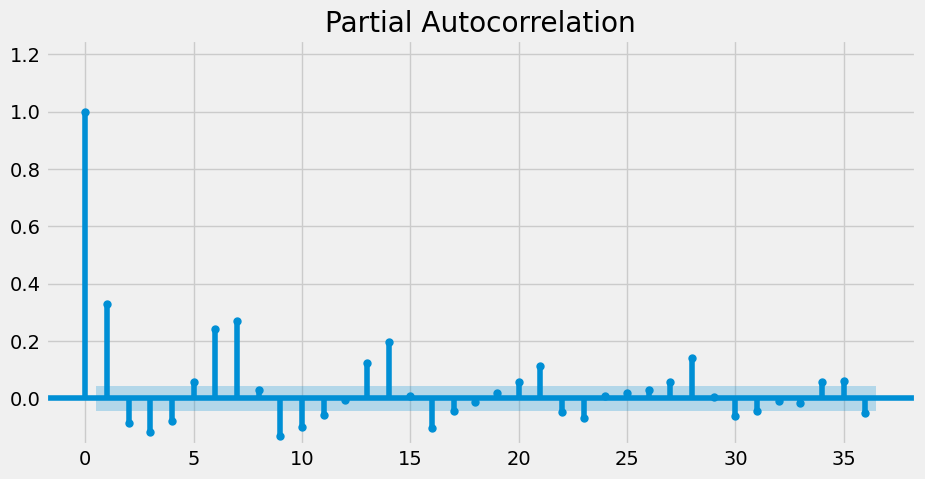

In [54]:
fig, ax = plt.subplots(figsize=[10, 5])
plot_pacf(
    x=data["sales"],
    method='ywmle', # Recommended method in Statsmodels notes
    lags=36,
    ax=ax,
    alpha=0.05,
    auto_ylims=True
)
plt.savefig('pacf.png')
plt.show()

<Axes: >

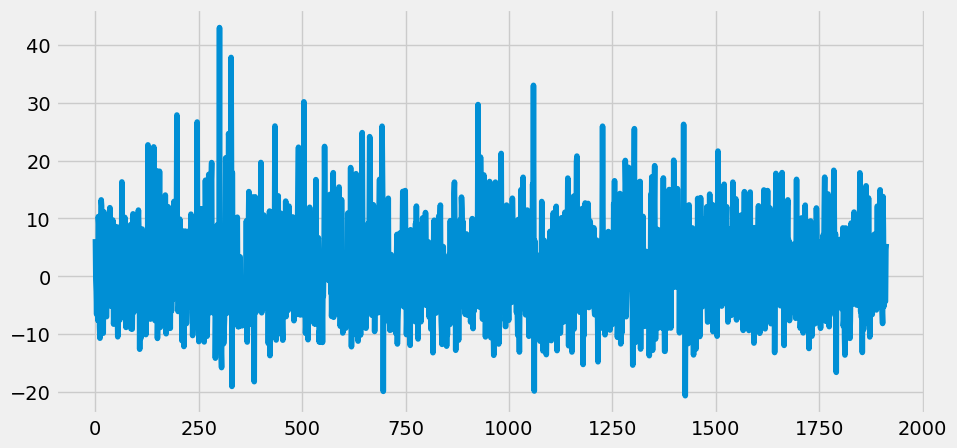

In [55]:
# Compute the trend with LOWESS
frac = 0.1
y = data["sales"]
x = np.arange(0, len(y))
res = lowess(endog=y, exog=x, frac=frac)
data["lowess"] = res[:, 1]

data["y_detrend"] = data["sales"] - data["lowess"]
data["y_detrend"].plot(figsize=(10, 5))

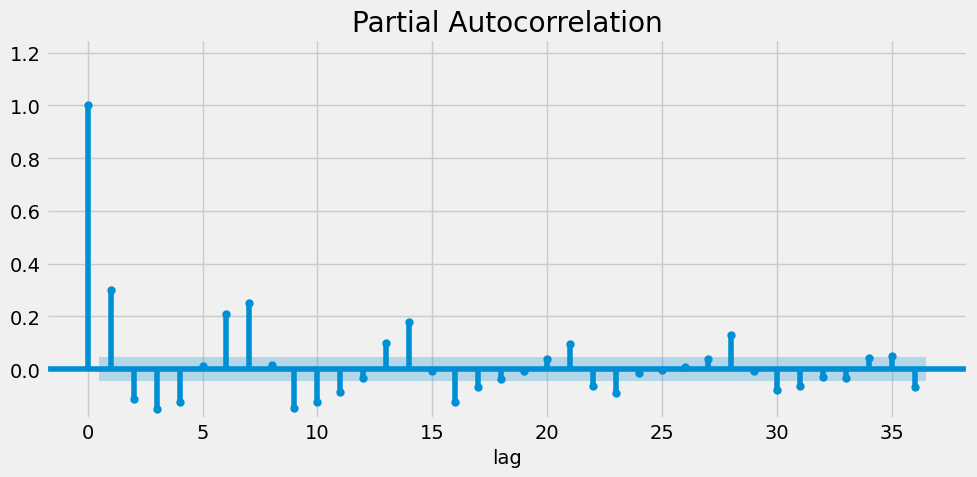

In [56]:
fig, ax = plt.subplots(figsize=[10, 5])
plot_pacf(
    x=data["y_detrend"],
    lags=36,
    ax=ax,
    alpha=0.05,
    auto_ylims=True
)
ax.set_xlabel("lag")
plt.tight_layout()
plt.savefig('de_trend_pacf.png')
plt.show()

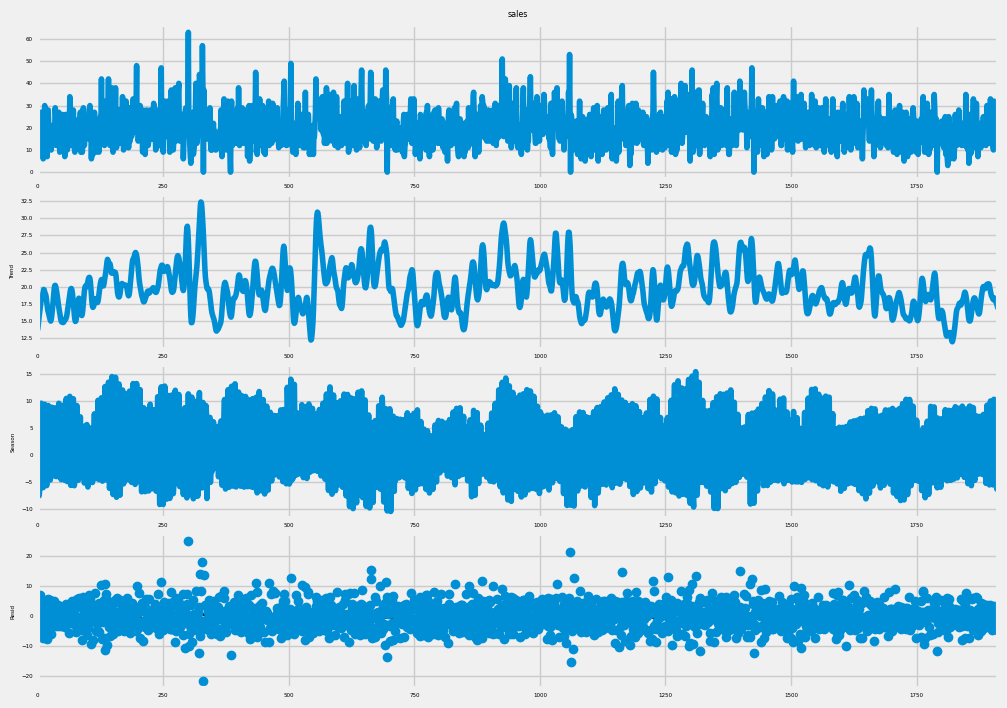

In [57]:
res1 = STL(data['sales'], period = 7).fit()

# Plot the full decomposition
plt.rc("figure", figsize=(10, 7))
plt.rc("font", size=4)
res1.plot();

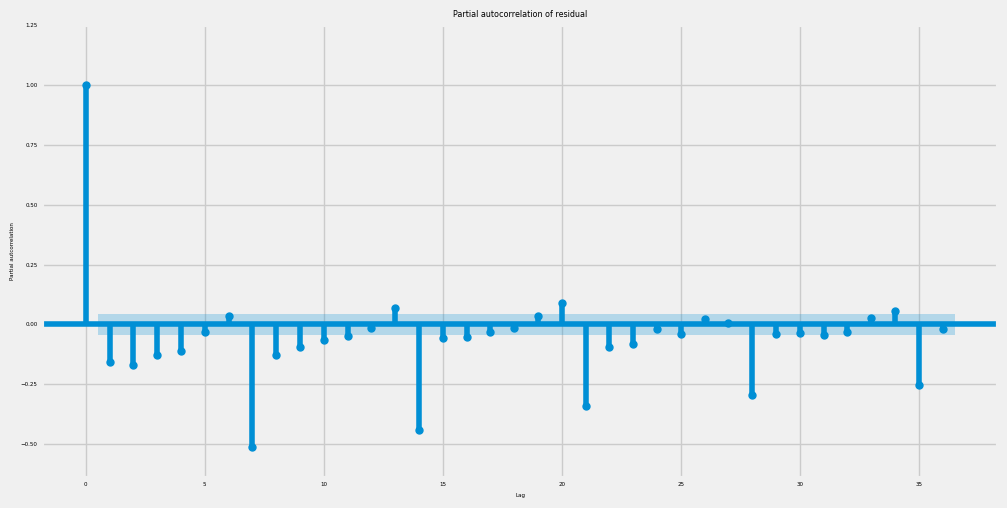

In [58]:
fig, ax = plt.subplots(figsize=[10, 5])
plot_pacf(
    x=res1.resid,
    lags=36,
    method='ywmle', # Recommended method in Statsmodels notes
    ax=ax,
    alpha=0.05,
    auto_ylims=True
)
ax.set_title("Partial autocorrelation of residual")
ax.set_ylabel("Partial autcorrelation")
ax.set_xlabel("Lag")
plt.tight_layout()
plt.savefig('res_pacf.png')
plt.show()

In [ ]:
# merging the calender data
# link to calender data: https://herts365-my.sharepoint.com/:x:/r/personal/sm22acy_herts_ac_uk/Documents/MSc_Project_21078559/calendar.csv?d=w7154d49e66f74fb0a2c8cf712803a38e&csf=1&web=1&e=IxtJmi

In [59]:
xcal = pd.read_csv('calendar.csv')
xcal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [ ]:
# merging the sales data and calendar data

In [60]:
data = pd.merge(data, xcal, on='d', how='left')
del xcal

In [61]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,lowess,y_detrend,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,FOODS_3_555_CA_1_validation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,d_1,23,16.583679,6.416321,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,FOODS_3_555_CA_1_validation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,d_2,16,16.597605,-0.597605,...,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,FOODS_3_555_CA_1_validation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,d_3,14,16.611645,-2.611645,...,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,FOODS_3_555_CA_1_validation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,d_4,10,16.625801,-6.625801,...,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,FOODS_3_555_CA_1_validation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,d_5,17,16.640074,0.359926,...,5,2,2011,NaN,NaN,NaN,NaN,1,0,1


In [62]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data.index.freq = 'D'

In [63]:
data.shape

(1913, 22)

In [64]:
#data['event_name_1'].value_counts()

In [65]:
#data['event_type_1'].value_counts()

In [ ]:
# using pd.get_dummies function to convert categorical variables into dummy/ indicator variables

In [66]:
data_encoded = pd.get_dummies(data, columns=['event_name_1','event_type_1','event_name_2','event_type_2'])

In [67]:
data_encoded.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,lowess,y_detrend,...,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_name_2_Cinco De Mayo,event_name_2_Easter,event_name_2_Father's day,event_name_2_OrthodoxEaster,event_type_2_Cultural,event_type_2_Religious
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,FOODS_3_555_CA_1_validation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,d_1,23,16.583679,6.416321,...,False,False,False,False,False,False,False,False,False,False
2011-01-30,FOODS_3_555_CA_1_validation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,d_2,16,16.597605,-0.597605,...,False,False,False,False,False,False,False,False,False,False
2011-01-31,FOODS_3_555_CA_1_validation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,d_3,14,16.611645,-2.611645,...,False,False,False,False,False,False,False,False,False,False
2011-02-01,FOODS_3_555_CA_1_validation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,d_4,10,16.625801,-6.625801,...,False,False,False,False,False,False,False,False,False,False
2011-02-02,FOODS_3_555_CA_1_validation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,d_5,17,16.640074,0.359926,...,False,False,False,False,False,False,False,False,False,False


In [68]:
data = data_encoded.drop(['id','item_id','dept_id','cat_id','store_id','state_id','wm_yr_wk','weekday'], axis=1)

In [69]:
data = data.drop(['d','wday','month'], axis=1)

In [70]:
data.head()

,sales,lowess,y_detrend,year,snap_CA,snap_TX,snap_WI,event_name_1_Chanukah End,event_name_1_Christmas,event_name_1_Cinco De Mayo,...,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_name_2_Cinco De Mayo,event_name_2_Easter,event_name_2_Father's day,event_name_2_OrthodoxEaster,event_type_2_Cultural,event_type_2_Religious
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,23,16.583679,6.416321,2011,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2011-01-30,16,16.597605,-0.597605,2011,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2011-01-31,14,16.611645,-2.611645,2011,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2011-02-01,10,16.625801,-6.625801,2011,1,1,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2011-02-02,17,16.640074,0.359926,2011,1,0,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [71]:
data.fillna(-1)

,sales,lowess,y_detrend,year,snap_CA,snap_TX,snap_WI,event_name_1_Chanukah End,event_name_1_Christmas,event_name_1_Cinco De Mayo,...,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_name_2_Cinco De Mayo,event_name_2_Easter,event_name_2_Father's day,event_name_2_OrthodoxEaster,event_type_2_Cultural,event_type_2_Religious
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,23,16.583679,6.416321,2011,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2011-01-30,16,16.597605,-0.597605,2011,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2011-01-31,14,16.611645,-2.611645,2011,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2011-02-01,10,16.625801,-6.625801,2011,1,1,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2011-02-02,17,16.640074,0.359926,2011,1,0,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-20,15,18.312595,-3.312595,2016,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2016-04-21,14,18.337316,-4.337316,2016,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2016-04-22,14,18.362149,-4.362149,2016,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [72]:
data.shape

(1913, 47)

#creating feature
# 7 days lag
freq = "1d"
data[f"y_lag_{freq}"] = data["sales"].shift(freq=freq)

freq = "2d"
data[f"y_lag_{freq}"] = data["sales"].shift(freq=freq)

freq = "3d"
data[f"y_lag_{freq}"] = data["sales"].shift(freq=freq)

freq = "4d"
data[f"y_lag_{freq}"] = data["sales"].shift(freq=freq)

freq = "5d"
data[f"y_lag_{freq}"] = data["sales"].shift(freq=freq)

freq = "6d"
data[f"y_lag_{freq}"] = data["sales"].shift(freq=freq)

freq = "7d"
data[f"y_lag_{freq}"] = data["sales"].shift(freq=freq)


data.head()


result = (
    data["sales"]
    .rolling(window=7) # Pick window size.
    .agg(["mean", "std"]) # Pick statistics.
    .shift(freq="1D") # Lag by 1 hour to avoid data leakage.
)  

result = result.add_prefix("y_window_7_")

# add features to main dataframe

data = data.merge(result, how="left", left_index=True, right_index=True)

data.head()

result = (
    data["sales"]
    .rolling(window=28) # Pick window size.
    .agg(["mean", "std"]) # Pick statistics.
    .shift(freq="1D") # Lag by 1 hour to avoid data leakage.
)  

result = result.add_prefix("y_window_28_")

# add features to main dataframe

data = data.merge(result, how="left", left_index=True, right_index=True)

data.head()

result = (
    data["sales"]
    .rolling(window=28) # Pick window size.
    .agg(["mean", "std"]) # Pick statistics.
    .shift(freq="1D") # Lag by 1 hour to avoid data leakage.
)  

result = result.add_prefix("y_window_28_")

# add features to main dataframe
data = data.merge(result, how="left", left_index=True, right_index=True)

data.head()

In [1]:
# creating date-time features

In [73]:
data["month"] = data.index.month
data["day"] = data.index.dayofweek

In [74]:
data.head()

,sales,lowess,y_detrend,year,snap_CA,snap_TX,snap_WI,event_name_1_Chanukah End,event_name_1_Christmas,event_name_1_Cinco De Mayo,...,event_type_1_Religious,event_type_1_Sporting,event_name_2_Cinco De Mayo,event_name_2_Easter,event_name_2_Father's day,event_name_2_OrthodoxEaster,event_type_2_Cultural,event_type_2_Religious,month,day
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,23,16.583679,6.416321,2011,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,1,5
2011-01-30,16,16.597605,-0.597605,2011,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,1,6
2011-01-31,14,16.611645,-2.611645,2011,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,1,0
2011-02-01,10,16.625801,-6.625801,2011,1,1,0,False,False,False,...,False,False,False,False,False,False,False,False,2,1
2011-02-02,17,16.640074,0.359926,2011,1,0,1,False,False,False,...,False,False,False,False,False,False,False,False,2,2


In [75]:
#finalise tabulaisation

end_train_date = datetime(2011, 1, 29) + timedelta(days=1421)
end_validation_date = end_train_date + timedelta(days=265)

# Split the data
data_train = data.loc[:end_train_date]
data_val = data.loc[end_train_date + timedelta(days=1):end_validation_date]
data_test = data.loc[end_validation_date + timedelta(days=1):]

In [76]:
print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validation : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-01-29 00:00:00 --- 2014-12-20 00:00:00  (n=1422)
Dates validation : 2014-12-21 00:00:00 --- 2015-09-11 00:00:00  (n=265)
Dates test       : 2015-09-12 00:00:00 --- 2016-04-24 00:00:00  (n=226)


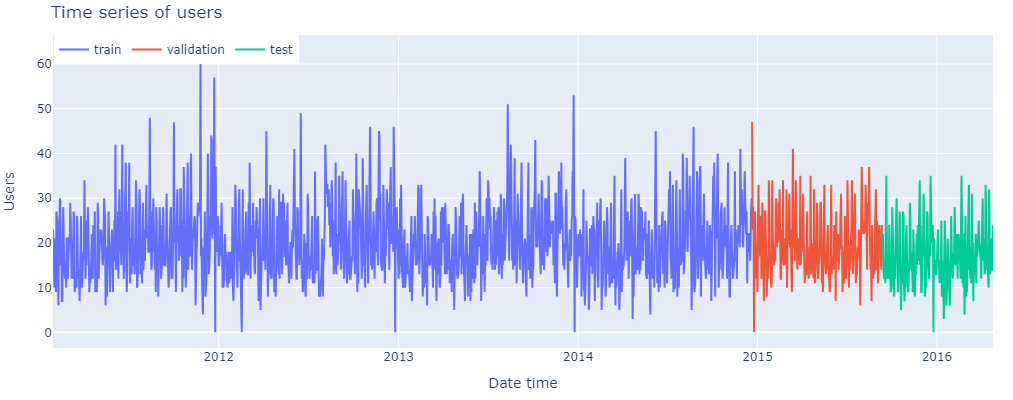

In [77]:
fig = go.Figure()
trace1 = go.Scatter(x=data_train.index, y=data_train['sales'], name="train", mode="lines")
trace2 = go.Scatter(x=data_val.index, y=data_val['sales'], name="validation", mode="lines")
trace3 = go.Scatter(x=data_test.index, y=data_test['sales'], name="test", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.add_trace(trace3)
fig.update_layout(
    title="Time series of users",
    xaxis_title="Date time",
    yaxis_title="Users",
    width  = 800,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

In [78]:
data.columns

Index(['sales', 'lowess', 'y_detrend', 'year', 'snap_CA', 'snap_TX', 'snap_WI',
       'event_name_1_Chanukah End', 'event_name_1_Christmas',
       'event_name_1_Cinco De Mayo', 'event_name_1_ColumbusDay',
       'event_name_1_Easter', 'event_name_1_Eid al-Fitr',
       'event_name_1_EidAlAdha', 'event_name_1_Father's day',
       'event_name_1_Halloween', 'event_name_1_IndependenceDay',
       'event_name_1_LaborDay', 'event_name_1_LentStart',
       'event_name_1_LentWeek2', 'event_name_1_MartinLutherKingDay',
       'event_name_1_MemorialDay', 'event_name_1_Mother's day',
       'event_name_1_NBAFinalsEnd', 'event_name_1_NBAFinalsStart',
       'event_name_1_NewYear', 'event_name_1_OrthodoxChristmas',
       'event_name_1_OrthodoxEaster', 'event_name_1_Pesach End',
       'event_name_1_PresidentsDay', 'event_name_1_Purim End',
       'event_name_1_Ramadan starts', 'event_name_1_StPatricksDay',
       'event_name_1_SuperBowl', 'event_name_1_Thanksgiving',
       'event_name_1_Valent

In [79]:
# Initialize the forecaster
forecaster = ForecasterAutoreg(
    regressor=LGBMRegressor(
        learning_rate=0.1,
        max_depth=6,
        n_estimators=500,
        num_leaves=30,
         objective = "tweedie",# Set num_leaves to be greater than 2^max_depth
        random_state=123,
        force_row_wise=True,
        # or force_col_wise=True if memory is a concern
    ),
    lags=[1,6,7,8,10,11] ,
    
)

#learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50, 'num_leaves': 2

In [80]:
initial_train_size = len(data_train) + len(data_val)  # Combined length of training and validation sets

print(initial_train_size)

1687


def custom_metric(y_true = data_test['sales'],  y_pred = np.round(predictions['pred'],2)):
    y_pred = np.round(y_pred,2)
    n = len(y_true)
    smape_values = []
    
    for i in range(n):
        if y_true[i] == 0 and y_pred[i] == 0:
            smape_values.append(0)
        else:
            denominator = (abs(y_true[i]) + abs(y_pred[i])) / 2
            numerator = abs(y_true[i] - y_pred[i])
            smape_values.append(numerator / denominator)
    
    return (100 / n) * sum(smape_values)

In [81]:
exog = data[['year', 'month',
       'day']]

exog = data[['year', 'snap_CA', 'snap_TX', 'snap_WI',
       'y_window_7_mean', 'y_window_7_std','y_window_14_mean', 'y_window_14_std', 'y_window_28_mean',
       'y_window_28_std', 'month', 'day']]

exog = data[['year', 'month', 'day']]

In [82]:
exog.dtypes

year     int64
month    int32
day      int32
dtype: object

In [83]:
for col in exog.select_dtypes(include=['bool']).columns:
    exog.loc[:, col] = exog.loc[:, col].astype('int')

In [84]:
exog.columns = exog.columns.str.replace(' ', '')

In [85]:
exog.dtypes

year     int64
month    int32
day      int32
dtype: object

In [86]:
metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=data['sales'],
    initial_train_size=initial_train_size,
    fixed_train_size=False,
    steps=10,
    refit=True,
    metric='mean_squared_error',
    verbose=True,
    exog = exog # Change to True for detailed information
)


print(f"Backtest error: {metric}")

[LightGBM] [Info] Total Bins 302
[LightGBM] [Info] Number of data points in the train set: 1676, number of used features: 9
[LightGBM] [Info] Start training from score 3.003281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

  0%|          | 0/23 [00:00<?, ?it/s]

Backtest error: 35.7947901394842


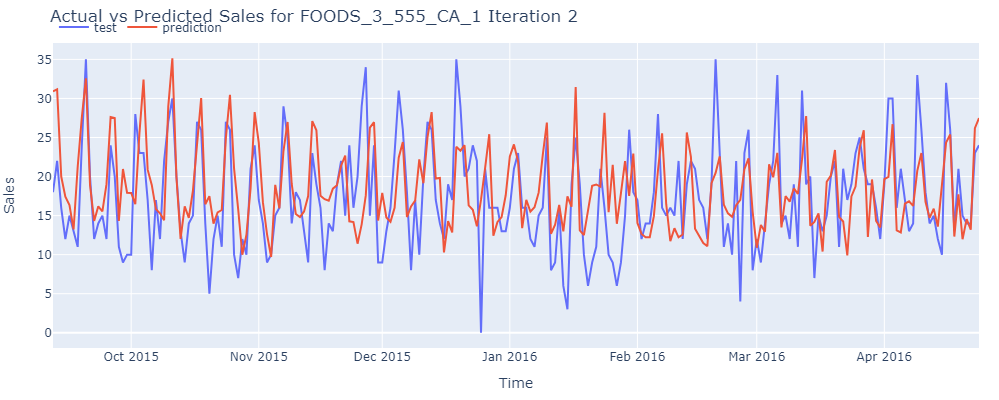

In [87]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['sales'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Actual vs Predicted Sales for FOODS_3_555_CA_1 Iteration 2",
    xaxis_title="Time",
    yaxis_title="Sales",
    width  = 800,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()
fig.write_image("actual_vs_predicted_FOODS_3_555_CA_1_Iteration_2.png")

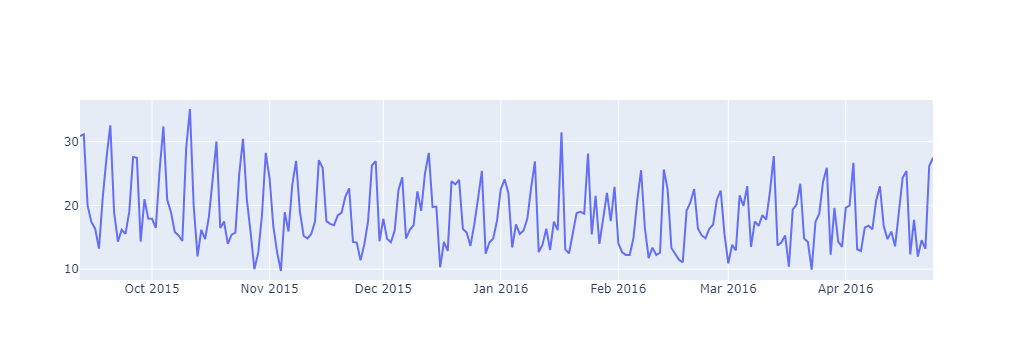

In [88]:
fig1 = go.Figure()
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig1.add_trace(trace2)

In [89]:
print(data_test['sales'])
print(np.round(predictions['pred'],2))

date
2015-09-12    18
2015-09-13    22
2015-09-14    16
2015-09-15    12
2015-09-16    15
              ..
2016-04-20    15
2016-04-21    14
2016-04-22    14
2016-04-23    23
2016-04-24    24
Freq: D, Name: sales, Length: 226, dtype: int8
2015-09-12    30.89
2015-09-13    31.16
2015-09-14    20.00
2015-09-15    17.41
2015-09-16    16.35
              ...  
2016-04-20    11.97
2016-04-21    14.55
2016-04-22    13.20
2016-04-23    26.20
2016-04-24    27.49
Freq: D, Name: pred, Length: 226, dtype: float64


In [90]:
comparison_df = pd.DataFrame({
    'Actual Sales': data_test['sales'],
    'Predicted Sales': np.round(predictions['pred'],2)
})

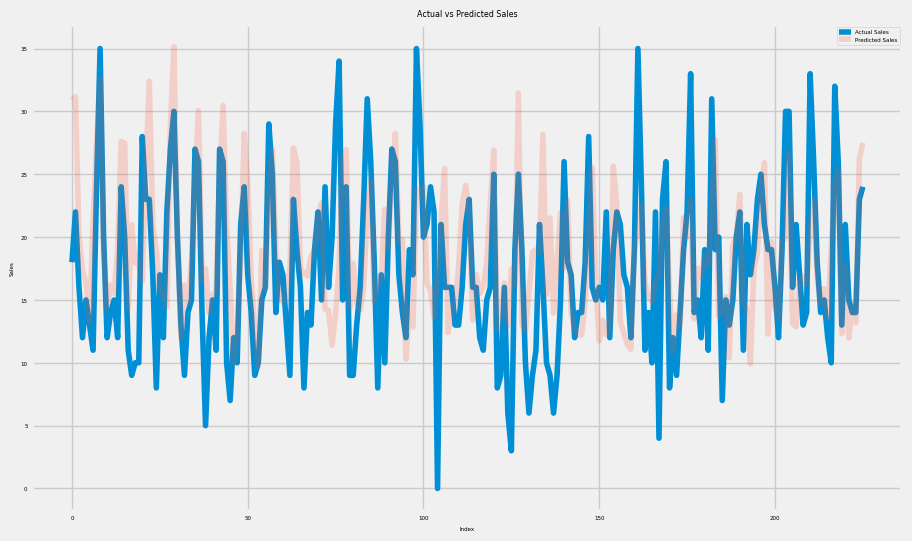

In [91]:
plt.figure(figsize=(10, 6))
plt.plot(data_test['sales'].values, label='Actual Sales')
plt.plot(predictions['pred'].values, label='Predicted Sales', alpha = 0.2)
plt.xlabel('Index')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()

# Grid search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(
                                 learning_rate = 0.1,
                                 max_depth     = 5,
                                 n_estimators  = 500,
                                 random_state  = 123,
                             ),
                 lags = 24
             )

# Lags used as predictors
lags_grid = [7,24, 48, 72]

# Regressor hyperparameters
param_grid = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
              'max_depth': [1, 2, 3, 4, 5, 6],
              'learning_rate': [0.01, 0.1],
               'num_leaves': [2, 4, 8, 16, 32, 64 ]}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data['sales'],
                   exog               = exog,
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = initial_train_size,
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )